<h1> Trabalho Final de Aprendizado de Máquina - UFC</h1>

<h3>Equipe: <b style="color:#1E90FF">Marcos Vinicius de Freitas Borges e Maria de Fátima Pinheiro Ferreira</b></h3>

In [30]:
import pandas as pd
import numpy as np
import re
from time import time
import seaborn as sns

# Vetorizar os textos
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from unicodedata import normalize
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE,ADASYN

# Classificadores
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

# Otimizador
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import matplotlib.pyplot as plt
%matplotlib inline

#Tirar depois
from collections import Counter
from scipy import sparse

<b style="color:#25aadb;font:bold 15px arial;">Ler o dataset</b> 

In [31]:
data_set = pd.read_csv("/Users/marcosborges/Documents/python/aulas_aprendizagem_automatica/data/dataSet_aprendizagem_automatica.csv")

In [32]:
stemmer = RSLPStemmer()

<b style="color:#25aadb;font:bold 15px arial;">Principais Funções</b> 

In [33]:
def aplicar_stop_words():
    lista_stop_words = stopwords.words('portuguese')

In [34]:
def limpar_texto(texto):
    
    caracteres_especiais = ["@", "#", "$", "%", "&", "*", "(", ")", "-", "_", "=", "+", "|", ":", ",", "."]
    numeros = ['0','1','2','3','4','5','6','7','8','9']
    caracteres = caracteres_especiais + numeros
    
    texto_normalizado = normalize('NFKD', texto).encode('ASCII','ignore').decode('ASCII')   
    for caracter in caracteres:
        texto_normalizado = texto_normalizado.replace(caracter.lower(), " ")

    return texto_normalizado

In [35]:
def tokenizacao(string):

    caracteres = ["!","#","$","%","&","(",")","*","+",",","-",".","/",":",";","<","=",">","?","@","[","\\","]","^","_",",","{","|","}"]
    palavras = string.strip()

    for i in range(1,len(string)):
        if (string[i] in caracteres and string[i-1] not in caracteres) and (string[i] != "" and string[i-1] != ""):
            palavras = palavras.replace(string[i-1] + string[i], string[i-1] + " " + string[i])
        elif (string[i-1] in caracteres and string[i] not in caracteres) and (string[i] != "" and string[i-1] != ""):
            palavras = palavras.replace(string[i-1] + string[i], string[i-1] + " " + string[i])

    palavras = re.sub("\s+", " ", palavras)
    palavras = palavras.strip().lower()
    palavras = palavras.split(" ")
    return palavras

In [36]:
def realizar_pre_processamento_comentarios():
    comentarios = data_set['comentario']
    comentarios_processados = []
    for i in range(len(comentarios)):
        lista_palavras = [stemmer.stem(p) for p in tokenizacao(limpar_texto(comentarios[i].strip())) if len(p) > 1]
        comentarios_processados.append(" ".join(lista_palavras))
    return comentarios_processados

In [37]:
def imprimir_metricas(y_test,y_predicted, y_predicted_proba):
    
    print(metrics.classification_report(y_test, y_predicted, digits=3))    
    print("Accuracy: ", round(metrics.accuracy_score(y_test, y_predicted),3))
    print("Recall: ", round(metrics.recall_score(y_test, y_predicted, average='weighted'),3))
    print("Precision: ", round(metrics.precision_score(y_test, y_predicted, average='weighted'),3))
    print("F1-score: ", round(metrics.f1_score(y_test, y_predicted, average='weighted'),3))
#     print("kappa: ", round(metrics.cohen_kappa_score(y_test, y_predicted),3)) 
    fpr, tpr, thresholds = metrics.roc_curve(y_test,y_predicted_proba,pos_label=None)
    print("Auc: ", round(metrics.auc(fpr, tpr),3))

In [38]:
def imprimir_matriz_confusao(y_test,y_predicted):

    matriz = confusion_matrix(y_test, y_predicted)
    print(matriz)

    ax = plt.axes()
    group_names = ['Verdadeiros Negativos','Falsos Positivos','Falsos Negativos','Verdadeiros Positivos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    matriz.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                         matriz.flatten()/np.sum(matriz)]
    labels = [f"{v1}\n{v2}\n({v3})" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    sns.heatmap(matriz, ax = ax, annot=labels, fmt="", cmap='Blues', linewidths=0.1, linecolor='gray',annot_kws={"fontsize":11})
    ax.set_title('Matriz de Confusão')
#     ax.set(xlabel='X', ylabel='Y')
    

In [39]:
def imprimir_curva_roc(y_test,y_predicted_proba):
    
    fpr, tpr, thresholds = metrics.roc_curve(y_test,y_predicted_proba,pos_label=None)
    fig, ax = plt.subplots()
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    plt.plot(fpr,tpr)
    plt.title("Curva Roc")
    plt.ylabel("Sensibilidade")
    plt.xlabel("1 - Especificidade")
    plt.show()

In [40]:
def imprimir_tempo(tempo):
    print("--- %s seconds ---" % round(tempo,2)) 

In [41]:
data_set['comentario'] = realizar_pre_processamento_comentarios()

In [42]:
X = data_set['comentario'].values
y = data_set['sentimento'].values

<b style="color:#25aadb;font:bold 15px arial;">Vetorizar Textos</b> 

In [43]:
tfidf = TfidfVectorizer(stop_words=aplicar_stop_words())

In [44]:
X, y = SMOTE().fit_resample(tfidf.fit_transform(X), y)

In [45]:
Counter(y)

Counter({0: 690, 1: 690})

In [46]:
X

<1380x2284 sparse matrix of type '<class 'numpy.float64'>'
	with 18451 stored elements in Compressed Sparse Row format>

In [47]:
# print(v.get_feature_names()) / get_stop_words

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

<b style='color:red;font:bold 15px arial;text-decoration:underline;'>GridSearh - MLP</b> 

In [357]:
param_grid = dict(activation=list(['logistic', 'tanh', 'relu']),solver=list(['lbfgs','adam']), hidden_layer_sizes=list([(100,),(130,),(150,)]))

inicio = time()
grid = GridSearchCV(MLPClassifier(), param_grid, scoring='accuracy', cv=10,n_jobs=-1)
grid.fit(X, y)
fim = time()

imprimir_tempo(fim-inicio)
print(grid.best_score_)
print(grid.best_params_)

pd.DataFrame(grid.cv_results_)[['mean_test_score','std_test_score','params']]

--- 850.4 seconds ---
0.8492753623188406
{'activation': 'relu', 'hidden_layer_sizes': (100,), 'solver': 'adam'}


,mean_test_score,std_test_score,params
0,0.828986,0.046648,"{'activation': 'logistic', 'hidden_layer_sizes..."
1,0.845652,0.041760,"{'activation': 'logistic', 'hidden_layer_sizes..."
2,0.833333,0.045021,"{'activation': 'logistic', 'hidden_layer_sizes..."
3,0.842754,0.042507,"{'activation': 'logistic', 'hidden_layer_sizes..."
4,0.821739,0.049594,"{'activation': 'logistic', 'hidden_layer_sizes..."
5,0.843478,0.039050,"{'activation': 'logistic', 'hidden_layer_sizes..."
6,0.823188,0.045044,"{'activation': 'tanh', 'hidden_layer_sizes': (..."
7,0.841304,0.044369,"{'activation': 'tanh', 'hidden_layer_sizes': (..."
8,0.823188,0.053171,"{'activation': 'tanh', 'hidden_layer_sizes': (..."
9,0.844928,0.045853,"{'activation': 'tanh', 'hidden_layer_sizes': (..."


<b style='color:green;font:bold 15px arial;text-decoration:underline'>Classificador MLP</b> 

--- 9.05 seconds ---
              precision    recall  f1-score   support

           0      0.805     0.870     0.836       161
           1      0.877     0.815     0.845       184

    accuracy                          0.841       345
   macro avg      0.841     0.842     0.840       345
weighted avg      0.843     0.841     0.841       345

Accuracy:  0.841
Recall:  0.841
Precision:  0.843
F1-score:  0.841
Auc:  0.916


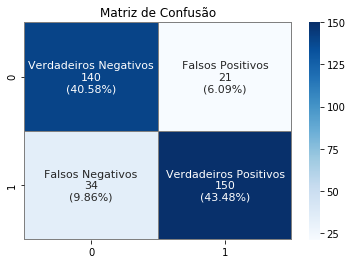

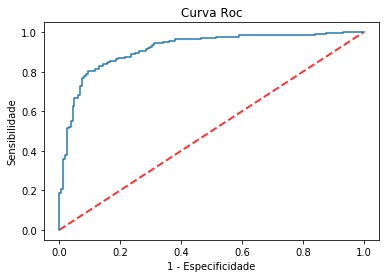

In [363]:
# Classificador MLP
inicio = time()
# classificador = MLPClassifier(random_state=5)
classificador = MLPClassifier(activation='relu', solver='adam', hidden_layer_sizes=(130,),random_state=5)
classificador.fit(X_train, y_train)
fim = time()

y_predicted = classificador.predict(X_test)
y_predicted_proba = classificador.predict_proba(X_test)[:,1]

imprimir_tempo(fim-inicio)
imprimir_metricas(y_test,y_predicted,y_predicted_proba)
imprimir_matriz_confusao(y_test,y_predicted)
imprimir_curva_roc(y_test,y_predicted_proba)
# pd.DataFrame(classificador.loss_curve_).plot()

<b style='color:red;font:bold 15px arial;text-decoration:underline;'>GridSearh - Random Forest</b>

In [354]:
#GridSerchCV para RandomForest

param_grid = dict(criterion=list(['gini','entropy']), n_estimators=list([100, 500, 1000, 1500]))

inicio = time()
grid = GridSearchCV(RandomForestClassifier(), param_grid, scoring='accuracy', cv=10,n_jobs=-1)
grid.fit(X, y)
fim = time()

imprimir_tempo(fim-inicio)
print(grid.best_score_)
print(grid.best_params_)

pd.DataFrame(grid.cv_results_)[['mean_test_score','std_test_score','params']]

--- 227.83 seconds ---
0.839855072463768
{'criterion': 'entropy', 'n_estimators': 1500}


,mean_test_score,std_test_score,params
0,0.833333,0.039023,"{'criterion': 'gini', 'n_estimators': 100}"
1,0.835507,0.038488,"{'criterion': 'gini', 'n_estimators': 500}"
2,0.835507,0.036814,"{'criterion': 'gini', 'n_estimators': 1000}"
3,0.835507,0.037660,"{'criterion': 'gini', 'n_estimators': 1500}"
4,0.834783,0.035173,"{'criterion': 'entropy', 'n_estimators': 100}"
5,0.837681,0.035970,"{'criterion': 'entropy', 'n_estimators': 500}"
6,0.837681,0.033239,"{'criterion': 'entropy', 'n_estimators': 1000}"
7,0.839855,0.036297,"{'criterion': 'entropy', 'n_estimators': 1500}"


<b style='color:green;font:bold 15px arial;text-decoration:underline'>Classificador Random Forest</b> 

--- 9.87 seconds ---
              precision    recall  f1-score   support

           0      0.799     0.826     0.812       149
           1      0.864     0.842     0.853       196

    accuracy                          0.835       345
   macro avg      0.831     0.834     0.832       345
weighted avg      0.836     0.835     0.835       345

Accuracy:  0.835
Recall:  0.835
Precision:  0.836
F1-score:  0.835
Auc:  0.919
[[123  26]
 [ 31 165]]


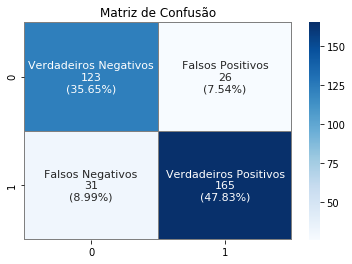

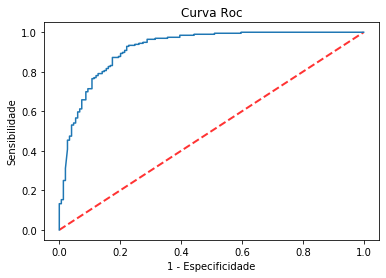

In [21]:
inicio = time()
# classificador = RandomForestClassifier(random_state=5)
classificador = RandomForestClassifier(criterion='entropy', n_estimators=1500,random_state=5)
classificador.fit(X_train, y_train)
fim = time()

y_predicted = classificador.predict(X_test)
y_predicted_proba = classificador.predict_proba(X_test)[:,1]

imprimir_tempo(fim-inicio)
imprimir_metricas(y_test,y_predicted,y_predicted_proba)
imprimir_matriz_confusao(y_test,y_predicted)
imprimir_curva_roc(y_test,y_predicted_proba)

<b style='color:red;font:bold 15px arial;text-decoration:underline;'>GridSearh - Árvore de Decisão</b> 

In [365]:
#GridSerchCV para Árvore de Decisão

param_grid = dict(criterion=list(['gini','entropy']), splitter=list(['best', 'random']), max_features=list([None, 'auto', 'sqrt', 'log2']))

inicio = time()
grid = GridSearchCV(DecisionTreeClassifier(random_state=5), param_grid, scoring='accuracy', cv=10,n_jobs=-1)
grid.fit(X, y)
fim = time()

imprimir_tempo(fim-inicio)
print(grid.best_score_)
print(grid.best_params_)

pd.DataFrame(grid.cv_results_)[['mean_test_score','std_test_score','params']]

--- 6.57 seconds ---
0.7659420289855073
{'criterion': 'entropy', 'max_features': None, 'splitter': 'random'}


,mean_test_score,std_test_score,params
0,0.755797,0.045143,"{'criterion': 'gini', 'max_features': None, 's..."
1,0.757971,0.038780,"{'criterion': 'gini', 'max_features': None, 's..."
2,0.740580,0.026880,"{'criterion': 'gini', 'max_features': 'auto', ..."
3,0.750725,0.058260,"{'criterion': 'gini', 'max_features': 'auto', ..."
4,0.740580,0.026880,"{'criterion': 'gini', 'max_features': 'sqrt', ..."
5,0.750725,0.058260,"{'criterion': 'gini', 'max_features': 'sqrt', ..."
6,0.736957,0.036239,"{'criterion': 'gini', 'max_features': 'log2', ..."
7,0.728986,0.048415,"{'criterion': 'gini', 'max_features': 'log2', ..."
8,0.752899,0.049726,"{'criterion': 'entropy', 'max_features': None,..."
9,0.765942,0.035061,"{'criterion': 'entropy', 'max_features': None,..."


<b style='color:green;font:bold 15px arial;text-decoration:underline'>Classificador Árvore de Decisão</b> 

--- 0.05 seconds ---
              precision    recall  f1-score   support

           0      0.751     0.722     0.737       180
           1      0.709     0.739     0.724       165

    accuracy                          0.730       345
   macro avg      0.730     0.731     0.730       345
weighted avg      0.731     0.730     0.731       345

Accuracy:  0.73
Recall:  0.73
Precision:  0.731
F1-score:  0.731
Auc:  0.729
[[130  50]
 [ 43 122]]


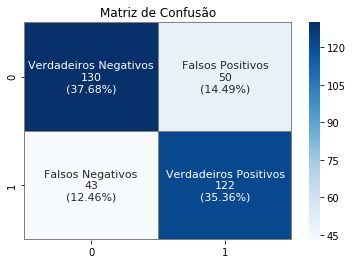

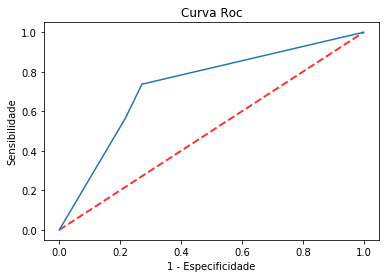

In [49]:
inicio = time()
# classificador = DecisionTreeClassifier(random_state=5)
# classificador = DecisionTreeClassifier(criterion='gini', max_features=None, splitter='best', random_state=5)
classificador = DecisionTreeClassifier(criterion='entropy', max_features=None, splitter='random', random_state=5)
classificador.fit(X_train, y_train)
fim = time()

y_predicted = classificador.predict(X_test)
y_predicted_proba = classificador.predict_proba(X_test)[:,1]

imprimir_tempo(fim-inicio)
imprimir_metricas(y_test,y_predicted,y_predicted_proba)
imprimir_matriz_confusao(y_test,y_predicted)
imprimir_curva_roc(y_test,y_predicted_proba)

<b style='color:#25aadb;font:bold 15px arial;text-decoration:underline'>Gráfico Sigmoide</b> 

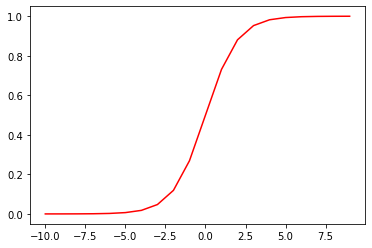

In [222]:
nums = np.arange(-10,10,step=1)
fig, ax = plt.subplots(figsize=(6,4))
reg = RegressaoLogistica()
ax.plot(nums, reg.sigmoid(nums), 'r')

<b style='color:#25aadb;font:bold 15px arial;text-decoration:underline'>Matriz esparsa</b> 

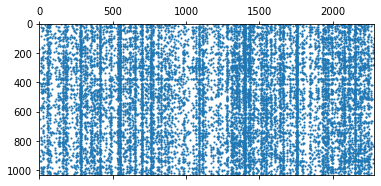

In [56]:
plt.spy(X_train,markersize=1)

In [23]:
from scipy.optimize import fmin_tnc
import numpy as np
from math import isnan
from scipy.special import expit
class RegressaoLogistica:
    
    loss=np.array([])
    #Função de Aivação
    def sigmoid(self,X):
        return expit(X) #Função especial do scipy que retorna 1/(1+exp(-x)) 

    def probability(self,theta, X):
        # Returns the probability after passing through sigmoid
        return self.sigmoid(X.dot(theta))

    def cost_function(self, theta, X, y):
        #Função que se baseia na Cross Entropy Loss (Pág. 14, slide AMA)
        # -1/N * Somatório (1 até N) -> Ei * Xi
            # Onde Ei = y - Sigmoid(W.T * Xi)
        N = X.shape[0]
        total_custo = -(1 / N) * np.sum(
            y * np.log(self.probability(theta, X)) + (1 - y) * np.log(
                1 - self.probability(theta, X)))
        if(isnan(total_custo)==False):
            self.loss = np.append(self.loss, total_custo)
        return total_custo

    def gradient(self, theta, X, y, alpha=0.1):
        N = X.shape[0]
        return alpha * (1/N) * X.T.dot(self.sigmoid(X.dot(theta)) - y)

    def fit(self,X, y,epochs=100):
        theta = np.zeros(X.shape[1])
        self.cost_function(theta, X,y)
        for _ in range(epochs):  
            opt_weights = fmin_tnc(func=self.cost_function,x0=theta,
                          fprime=self.gradient, args=(X, y.flatten()))
            theta += opt_weights[0] # Retorno do gradiente
            self.weights = opt_weights[0]
        
    def predict(self, X):        
        y_predicted = np.array([])
        z = X.dot(self.weights)
        # Returning binary result
        y_predicted = np.append(y_predicted,[1 if i > 0.5 else 0 for i in self.sigmoid(z)])
        return y_predicted
    
    def predict_proba(self, X):
        y_predicted_proba = np.array([])
        y_predicted_proba = np.append(y_predicted_proba, X.dot(self.weights))
        return y_predicted_proba

<b style='color:green;font:bold 15px arial;text-decoration:underline'>Classificador Regressão Logística</b> 

/Users/marcosborges/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log
/Users/marcosborges/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in multiply
/Users/marcosborges/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log
/Users/marcosborges/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in multiply


--- 3.48 seconds ---
              precision    recall  f1-score   support

           0      0.729     0.866     0.791       149
           1      0.881     0.755     0.813       196

    accuracy                          0.803       345
   macro avg      0.805     0.810     0.802       345
weighted avg      0.815     0.803     0.804       345

Accuracy:  0.803
Recall:  0.803
Precision:  0.815
F1-score:  0.804
Auc:  0.911
[[129  20]
 [ 48 148]]


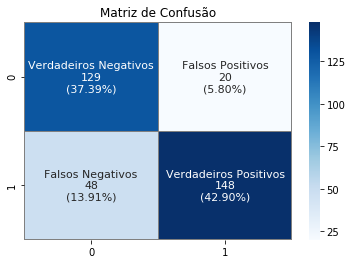

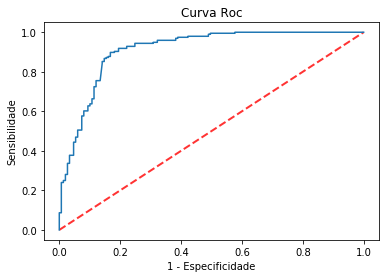

In [24]:
inicio = time()
reg_sparse = RegressaoLogistica()
reg_sparse.fit(X_train,y_train)
fim = time()

y_predicted = reg_sparse.predict(X_test)
y_predicted_proba = reg_sparse.predict_proba(X_test)

imprimir_tempo(fim-inicio)
imprimir_metricas(y_test,y_predicted,y_predicted_proba)
imprimir_matriz_confusao(y_test,y_predicted)
imprimir_curva_roc(y_test,y_predicted_proba)

<b style='color:red;font:bold 15px arial;text-decoration:underline;'>GridSearh - BernoulliNB</b> 

In [25]:
#GridSerchCV para BernoulliNB

param_grid = dict(alpha=list([0.1, 0.3, 0.5, 0.8 ,1]))

inicio = time() 
grid = GridSearchCV(BernoulliNB(), param_grid, scoring='accuracy', cv=10,n_jobs=-1)
grid.fit(X_train.toarray(), y_train)
fim = time()

imprimir_tempo(fim-inicio)
print(grid.best_score_)
print(grid.best_params_)

pd.DataFrame(grid.cv_results_)[['mean_test_score','std_test_score','params']]

--- 3.75 seconds ---
0.7922423450336071
{'alpha': 0.1}


,mean_test_score,std_test_score,params
0,0.792242,0.032776,{'alpha': 0.1}
1,0.775756,0.038873,{'alpha': 0.3}
2,0.766122,0.041252,{'alpha': 0.5}
3,0.761286,0.045842,{'alpha': 0.8}
4,0.762257,0.044387,{'alpha': 1}


<b style='color:green;font:bold 15px arial;text-decoration:underline'>Classificador BernoulliNB</b> 

--- 0.05 seconds ---
              precision    recall  f1-score   support

           0      0.876     0.664     0.756       149
           1      0.784     0.929     0.850       196

    accuracy                          0.814       345
   macro avg      0.830     0.797     0.803       345
weighted avg      0.824     0.814     0.810       345

Accuracy:  0.814
Recall:  0.814
Precision:  0.824
F1-score:  0.81
Auc:  0.914
[[ 99  50]
 [ 14 182]]


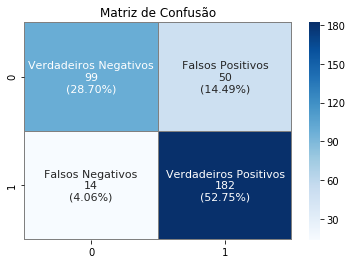

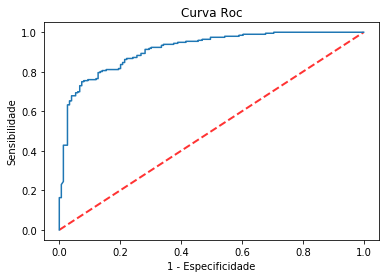

In [26]:
inicio = time()
# classificador = BernoulliNB()
classificador = BernoulliNB(alpha=0.1)
classificador.fit(X_train.toarray(), y_train)
fim = time()

y_predicted = classificador.predict(X_test.toarray())
y_predicted_proba = classificador.predict_proba(X_test.toarray())[:,1]

imprimir_tempo(fim-inicio)
imprimir_metricas(y_test,y_predicted,y_predicted_proba)
imprimir_matriz_confusao(y_test,y_predicted)
imprimir_curva_roc(y_test,y_predicted_proba)

In [27]:
#GridSerchCV para KNN

param_grid = dict(n_neighbors=list([5, 10, 20]), weights= list(['uniform', 'distance']))

inicio = time() 
grid = GridSearchCV(KNeighborsClassifier(), param_grid, scoring='accuracy', cv=10,n_jobs=-1)
grid.fit(X_train, y_train)
fim = time()

imprimir_tempo(fim-inicio)
print(grid.best_score_)
print(grid.best_params_)

pd.DataFrame(grid.cv_results_)[['mean_test_score','std_test_score','params']]

--- 0.68 seconds ---
0.4830937266616878
{'n_neighbors': 5, 'weights': 'distance'}


,mean_test_score,std_test_score,params
0,0.478258,0.003909,"{'n_neighbors': 5, 'weights': 'uniform'}"
1,0.483094,0.005827,"{'n_neighbors': 5, 'weights': 'distance'}"
2,0.477287,0.003135,"{'n_neighbors': 10, 'weights': 'uniform'}"
3,0.482123,0.004363,"{'n_neighbors': 10, 'weights': 'distance'}"
4,0.477287,0.003135,"{'n_neighbors': 20, 'weights': 'uniform'}"
5,0.482123,0.004363,"{'n_neighbors': 20, 'weights': 'distance'}"


--- 0.0 seconds ---
              precision    recall  f1-score   support

           0      0.750     0.020     0.039       149
           1      0.572     0.995     0.726       196

    accuracy                          0.574       345
   macro avg      0.661     0.508     0.383       345
weighted avg      0.649     0.574     0.430       345

Accuracy:  0.574
Recall:  0.574
Precision:  0.649
F1-score:  0.43
Auc:  0.452
[[  3 146]
 [  1 195]]


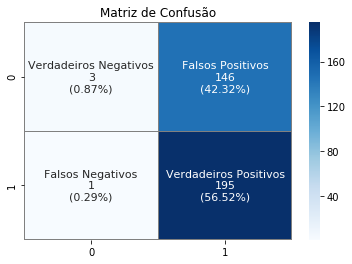

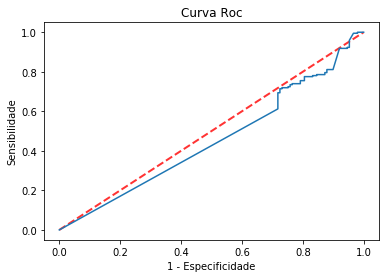

In [28]:
inicio = time()
# classificador = KNeighborsClassifier()
classificador = KNeighborsClassifier(n_neighbors=5, weights='distance')
classificador.fit(X_train, y_train)
fim = time() 

y_predicted = classificador.predict(X_test)
y_predicted_proba = classificador.predict_proba(X_test)[:,1]

imprimir_tempo(fim-inicio)
imprimir_metricas(y_test,y_predicted,y_predicted_proba)
imprimir_matriz_confusao(y_test,y_predicted)
imprimir_curva_roc(y_test,y_predicted_proba)
# metrics.recall_score(y_test,y_predicted, average='weighted')